In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [27]:
import pandas as pd


meta = pd.read_csv("/kaggle/input/meta-full-data-cleaned/original.csv")
data = pd.read_csv("/kaggle/input/meta-full-data-cleaned/2024_S1_cdm_ccsds_AE.csv")

# Compare columns
print("Metadata file columns:")
print(meta.columns)

print("\nData file columns:")
print(data.columns)

# Compare shapes
print("\nMetadata shape:", meta.shape)
print("Data shape:", data.shape)


Metadata file columns:
Index(['conjunction_id', 'ccsds_cdm_vers', 'comment_header', 'creation_date',
       'originator', 'classification', 'message_for', 'message_id', 'event_id',
       'comment_relative_metadata_data',
       ...
       'object2_ctdot_t', 'object2_ctdot_n', 'object2_ctdot_rdot',
       'object2_ctdot_tdot', 'object2_cndot_r', 'object2_cndot_t',
       'object2_cndot_n', 'object2_cndot_rdot', 'object2_cndot_tdot',
       'object2_cndot_ndot'],
      dtype='object', length=160)

Data file columns:
Index(['conjunction_id', 'comment_header', 'creation_date', 'originator',
       'message_id', 'event_id', 'comment_relative_metadata_data', 'tca',
       'miss_distance', 'relative_speed',
       ...
       'object2_ctdot_t', 'object2_ctdot_n', 'object2_ctdot_rdot',
       'object2_ctdot_tdot', 'object2_cndot_r', 'object2_cndot_t',
       'object2_cndot_n', 'object2_cndot_rdot', 'object2_cndot_tdot',
       'object2_cndot_ndot'],
      dtype='object', length=117)

Metadata 

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


In [28]:
DATA_PATH = "/kaggle/input/meta-full-data-cleaned/2024_S1_cdm_ccsds_AE.csv"   
META_PATH = "/kaggle/input/meta-full-data-cleaned/original.csv" 

# 1. load data
df = pd.read_csv(DATA_PATH)
print("data shape:", df.shape)
print(df.columns.tolist()[:40])  # preview columns

data shape: (185511, 117)
['conjunction_id', 'comment_header', 'creation_date', 'originator', 'message_id', 'event_id', 'comment_relative_metadata_data', 'tca', 'miss_distance', 'relative_speed', 'relative_position_r', 'relative_position_t', 'relative_position_n', 'relative_velocity_r', 'relative_velocity_t', 'relative_velocity_n', 'start_screen_period', 'stop_screen_period', 'screen_volume_radius', 'collision_probability', 'collision_probability_method', 'collision_max_probability', 'collision_max_pc_method', 'previous_message_id', 'comment_object1_metadata', 'object1_object_designator', 'object1_catalog_name', 'object1_object_name', 'object1_international_designator', 'object1_object_type', 'object1_ephemeris_name', 'object1_covariance_method', 'object1_maneuverable', 'object1_orbit_center', 'object1_ref_frame', 'object1_cov_type', 'comment_object1_od_parameters', 'comment_object1_data_additional_parameters', 'object1_area_pc', 'object1_area_pc_max']


In [ ]:


# 2. select useful numeric features for clustering
features = [
    'miss_distance',
    'relative_speed',
    'relative_position_r',
    'relative_position_t',
    'relative_position_n',
    'relative_velocity_r',
    'relative_velocity_t',
    'relative_velocity_n',
    'collision_probability',
    'collision_max_probability'
]

# keep only features that exist in the file
features = [f for f in features if f in df.columns]
print("using features:", features)

X = df[features].copy()

# 3. basic cleaning
# replace placeholder invalid values (if present) and drop rows with many NaNs
X.replace([-999999, -1e+06, 999999], np.nan, inplace=True)
X.dropna(axis=0, how='any', inplace=True)   # strict: drop rows with any missing in chosen features
print("after dropna shape:", X.shape)

# 4. quick statistics & pairplot
print(X.describe().T)
sns.pairplot(X.sample(min(1000, len(X))), diag_kind='kde', height=2.0)
plt.suptitle("Pairplot sample (features)", y=1.02)
plt.show()

# 5. scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. K-Means: find good k using elbow and silhouette
inertia = []
silhouettes = []
K_RANGE = range(2, 10)
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertia, '-o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), silhouettes, '-o')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.tight_layout()
plt.show()


k_best = 4
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)
df_k = df.loc[X.index].copy()
df_k['kcluster'] = k_labels

# summary table per cluster
cluster_summary = df_k.groupby('kcluster')[features].agg(['count', 'mean', 'std']).round(4)
print(cluster_summary)

# visualize clusters on two meaningful axes (miss_distance vs relative_speed)
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_k['miss_distance'], y=df_k['relative_speed'], hue=df_k['kcluster'], palette='tab10', s=20)
plt.xlabel('miss_distance')
plt.ylabel('relative_speed')
plt.title(f'KMeans clusters (k={k_best})')
plt.legend(title='cluster')
plt.show()

# 7. DBSCAN for irregular clusters & anomaly as noise (-1)
# choose eps: use k-distance plot on nearest neighbors
neighbors = 5
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, neighbors-1], axis=0)

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.xlabel('samples sorted')
plt.ylabel(f'{neighbors}-NN distance')
plt.title('k-distance plot for DBSCAN eps selection')
plt.show()

# set eps manually based on knee of the plot; example eps=1.2
eps_value = 1.2
db = DBSCAN(eps=eps_value, min_samples=5)
db_labels = db.fit_predict(X_scaled)
df_db = df.loc[X.index].copy()
df_db['db_cluster'] = db_labels

print("DBSCAN cluster value counts:\n", pd.Series(db_labels).value_counts())

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_db['miss_distance'], y=df_db['relative_speed'], hue=df_db['db_cluster'], palette='coolwarm', s=20)
plt.xlabel('miss_distance')
plt.ylabel('relative_speed')
plt.title(f'DBSCAN clusters (eps={eps_value})')
plt.show()

# 8. Isolation Forest for anomaly detection
iso = IsolationForest(contamination=0.03, random_state=42)
iso_labels = iso.fit_predict(X_scaled)   # 1 = normal, -1 = anomaly
df_iso = df.loc[X.index].copy()
df_iso['iso_anomaly'] = iso_labels

# count anomalies
anomaly_count = (df_iso['iso_anomaly'] == -1).sum()
print("Isolation Forest anomalies:", anomaly_count)

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_iso['miss_distance'], y=df_iso['relative_speed'], hue=df_iso['iso_anomaly'], palette={1:'blue', -1:'red'}, s=20)
plt.xlabel('miss_distance')
plt.ylabel('relative_speed')
plt.title('Isolation Forest anomalies (red)')
plt.show()

# 9. combine anomaly outputs 
summary = pd.DataFrame({
    'conjunction_id': df.loc[X.index, 'conjunction_id'],
    'miss_distance': df.loc[X.index, 'miss_distance'],
    'relative_speed': df.loc[X.index, 'relative_speed'],
    'kcluster': df_k['kcluster'].values,
    'db_cluster': df_db['db_cluster'].values,
    'iso_anomaly': df_iso['iso_anomaly'].values
})

# mark rows considered anomalous by any method
summary['any_anomaly'] = ((summary['db_cluster'] == -1) | (summary['iso_anomaly'] == -1))
print("Total flagged by at least one method:", summary['any_anomaly'].sum())

# save outputs
summary.to_csv("/content/clustering_anomaly_summary.csv", index=False)
cluster_summary.to_csv("/content/kmeans_cluster_summary.csv")
print("Saved summary files to /content/")


In [ ]:
import numpy as np

df['rel_pos_mag'] = np.sqrt(df['relative_position_r']**2 + df['relative_position_t']**2 + df['relative_position_n']**2)
df['rel_vel_mag'] = np.sqrt(df['relative_velocity_r']**2 + df['relative_velocity_t']**2 + df['relative_velocity_n']**2)

In [ ]:
for col in ['miss_distance', 'relative_speed', 'rel_pos_mag', 'rel_vel_mag']:
    df[col + '_log'] = np.log1p(df[col])

In [ ]:
features = ['miss_distance_log', 'relative_speed_log', 'rel_pos_mag_log', 
            'rel_vel_mag_log', 'collision_probability', 'collision_max_probability']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# test different k values
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette={sil:.4f}")

In [ ]:
df['kcluster'] = km.fit_predict(X_scaled)
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df['miss_distance'], y=df['relative_speed'], hue=df['kcluster'], palette='viridis', s=20)
plt.title('Clusters after log + magnitude transformation')
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.02, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)

sns.scatterplot(x=df['miss_distance'], y=df['relative_speed'], hue=df['anomaly'], palette={1:'blue', -1:'red'})
plt.title('Anomaly Detection - Isolation Forest')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='miss_distance', data=df, palette='viridis')
plt.title('Miss Distance Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Miss Distance (km)')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='relative_speed', data=df, palette='mako')
plt.title('Relative Speed Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Relative Speed (m/s)')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='collision_probability', data=df, palette='coolwarm')
plt.yscale('log')  # 
plt.title('Collision Probability per Cluster (log scale)')
plt.xlabel('Cluster')
plt.ylabel('Collision Probability')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='miss_distance', y='collision_probability', hue='kcluster', data=df, palette='viridis', s=15)
plt.yscale('log')
plt.title('Collision Probability vs Miss Distance by Cluster')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='miss_distance', y='relative_speed', hue='anomaly', data=df,
                palette={1:'blue', -1:'red'}, s=15)
plt.title('Anomaly Detection - Isolation Forest')
plt.xlabel('Miss Distance (km)')
plt.ylabel('Relative Speed (m/s)')
plt.show()

In [ ]:
# ============================================================
#  Clustering & Anomaly Detection Visualization
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="viridis")

# ----------------------------
# 1️ Miss Distance Distribution per Cluster
# ----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='miss_distance', data=df, palette='viridis')
plt.title('Miss Distance Distribution per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Miss Distance (km)', fontsize=12)
plt.tight_layout()
plt.show()

# ----------------------------
# 2️Relative Speed Distribution per Cluster
# ----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='relative_speed', data=df, palette='mako')
plt.title('Relative Speed Distribution per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Relative Speed (m/s)', fontsize=12)
plt.tight_layout()
plt.show()

# ----------------------------
# 3️ Collision Probability per Cluster (log scale)
# ----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='kcluster', y='collision_probability', data=df, palette='coolwarm')
plt.yscale('log')
plt.title('Collision Probability per Cluster (log scale)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Collision Probability (log)', fontsize=12)
plt.tight_layout()
plt.show()

# ----------------------------
# 4️ Scatter: Collision Probability vs Miss Distance
# ----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='miss_distance', y='collision_probability', hue='kcluster', 
                data=df, palette='viridis', s=15)
plt.yscale('log')
plt.title('Collision Probability vs Miss Distance by Cluster', fontsize=14)
plt.xlabel('Miss Distance (km)', fontsize=12)
plt.ylabel('Collision Probability (log)', fontsize=12)
plt.tight_layout()
plt.show()

# ----------------------------
# 5️  Anomaly Detection (Isolation Forest)
# ----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='miss_distance', y='relative_speed', hue='anomaly', data=df,
                palette={1:'blue', -1:'red'}, s=15)
plt.title('Anomaly Detection - Isolation Forest', fontsize=14)
plt.xlabel('Miss Distance (km)', fontsize=12)
plt.ylabel('Relative Speed (m/s)', fontsize=12)
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'], loc='upper right')
plt.tight_layout()
plt.show()

# ----------------------------
# 6️  Cluster Size Summary
# ----------------------------
plt.figure(figsize=(7,5))
sns.countplot(x='kcluster', data=df, palette='viridis')
plt.title('Number of Events per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# ----------------------------
#  Cluster Statistics Table
# ----------------------------
summary = df.groupby('kcluster')[['miss_distance', 'relative_speed', 
                                  'collision_probability', 'collision_max_probability']].mean()
print("Cluster Summary (Mean Values):")
print(summary.round(6))

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=50)
df['dbcluster'] = db.fit_predict(X_scaled)

sns.scatterplot(x='miss_distance', y='relative_speed', hue='dbcluster', data=df, palette='tab10', s=15)
plt.title('DBSCAN Clustering Result')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df[features].corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
import joblib

# Save the KMeans model
joblib.dump(kmeans, 'kmeans_model.joblib')
print("KMeans model saved as 'kmeans_model.joblib'")

# Save the Isolation Forest model
joblib.dump(iso, 'isolation_forest_model.joblib')
print("Isolation Forest model saved as 'isolation_forest_model.joblib'")

In [29]:
import joblib

# Load the KMeans model
loaded_kmeans_model = joblib.load('kmeans_model.joblib')
print("KMeans model loaded successfully.")

# Load the Isolation Forest model
loaded_iso_model = joblib.load('isolation_forest_model.joblib')
print("Isolation Forest model loaded successfully.")

# You can now use 'loaded_kmeans_model' and 'loaded_iso_model' for predictions or further analysis.

KMeans model loaded successfully.
Isolation Forest model loaded successfully.


In [30]:
from sklearn.neighbors import NearestNeighbors

# 1. Initialize NearestNeighbors with n_neighbors set to 5
n_neighbors_val = 5
nbrs = NearestNeighbors(n_neighbors=n_neighbors_val).fit(X_scaled)

# 2. Use the .kneighbors() method to obtain the distances
distances, indices = nbrs.kneighbors(X_scaled)

# 3. Extract the distances corresponding to the 5th (index 4) nearest neighbor
k_distance = distances[:, n_neighbors_val-1]

# 4. Add these extracted distances as a new column named 'knn_distance' to the DataFrame df
# Ensure correct alignment by using the index of X (which corresponds to df.loc[X.index])
df.loc[X.index, 'knn_distance'] = k_distance

print("Calculated KNN distances and added 'knn_distance' column to df.")
print(df[['miss_distance', 'relative_speed', 'knn_distance']].head())

Calculated KNN distances and added 'knn_distance' column to df.
   miss_distance  relative_speed  knn_distance
0     360.998008     4152.541202      0.014342
1     230.331161     6774.705183      0.042294
2     203.939751     8049.963408      0.013241
3     391.652906     9631.056058      0.002378
4     394.310175     1069.289496      0.024522


In [32]:
from sklearn.ensemble import IsolationForest

# 1. Initialize Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)

# 2. Fit the model on scaled features
iso.fit(X_scaled)

# 3. Calculate anomaly scores (decision_function returns continuous values)
anomaly_scores = iso.decision_function(X_scaled)

# Optional: also get binary predictions if needed
# binary_labels = iso.predict(X_scaled)  # 1 = normal, -1 = anomaly

# 4. Add anomaly scores as a new column in the dataframe
df.loc[X.index, 'anomaly_score'] = anomaly_scores

print("Calculated Isolation Forest anomaly scores and added 'anomaly_score' column to df.")
print(df[['miss_distance', 'relative_speed', 'anomaly_score']].head())

Calculated Isolation Forest anomaly scores and added 'anomaly_score' column to df.
   miss_distance  relative_speed  anomaly_score
0     360.998008     4152.541202       0.207821
1     230.331161     6774.705183       0.129971
2     203.939751     8049.963408       0.183396
3     391.652906     9631.056058       0.220204
4     394.310175     1069.289496       0.094670


In [23]:
df.describe()

,conjunction_id,event_id,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,...,rel_pos_mag,rel_vel_mag,miss_distance_log,relative_speed_log,rel_pos_mag_log,rel_vel_mag_log,kcluster,anomaly,dbcluster,knn_distance
count,1.855110e+05,1.855110e+05,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,...,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000,185511.000000
mean,1.173561e+07,7.433601e+06,315.595593,7414.595895,0.067099,0.712483,0.727559,-0.236304,-5008.390666,32.925104,...,315.595593,7414.595895,5.649621,8.050661,5.649621,8.050661,2.437791,0.959992,0.089553,0.027042
std,4.242427e+06,2.775533e+06,121.299285,4512.002830,221.119126,205.662092,152.062574,89.894022,4978.863700,5045.030931,...,121.299285,4512.002830,0.530747,2.562788,0.530747,2.562788,2.590314,0.280030,0.306307,0.770783
min,4.373225e+06,2.876025e+06,1.582203,0.002862,-499.907830,-499.683936,-497.938408,-7639.367025,-16510.930520,-9843.461334,...,1.582203,0.002862,0.948643,0.002858,0.948643,0.002858,0.000000,-1.000000,-1.000000,0.000282
25%,8.041204e+06,4.966739e+06,224.220467,4644.384905,-162.995052,-136.323673,-92.894835,-6.098343,-7270.911394,-4433.421132,...,224.220467,4644.384904,5.417080,8.443630,5.417080,8.443630,0.000000,1.000000,0.000000,0.004373
50%,1.173604e+07,7.339368e+06,329.618681,6961.857788,-0.602592,0.570418,0.416752,0.002168,-3191.855818,-0.025798,...,329.618681,6961.857788,5.800966,8.848345,5.800966,8.848345,2.000000,1.000000,0.000000,0.008108
75%,1.514299e+07,9.636746e+06,419.414860,10473.114520,164.482662,137.927219,93.703630,5.915952,-1420.589194,4433.751583,...,419.414860,10473.114519,6.041242,9.256662,6.041242,9.256662,6.000000,1.000000,0.000000,0.016270
max,2.020124e+07,1.304690e+07,499.999072,16859.543890,499.912278,499.495096,498.867326,3285.744496,1316.339440,9904.998873,...,499.999072,16859.543884,6.216604,9.732731,6.216604,9.732731,6.000000,1.000000,1.000000,233.692361


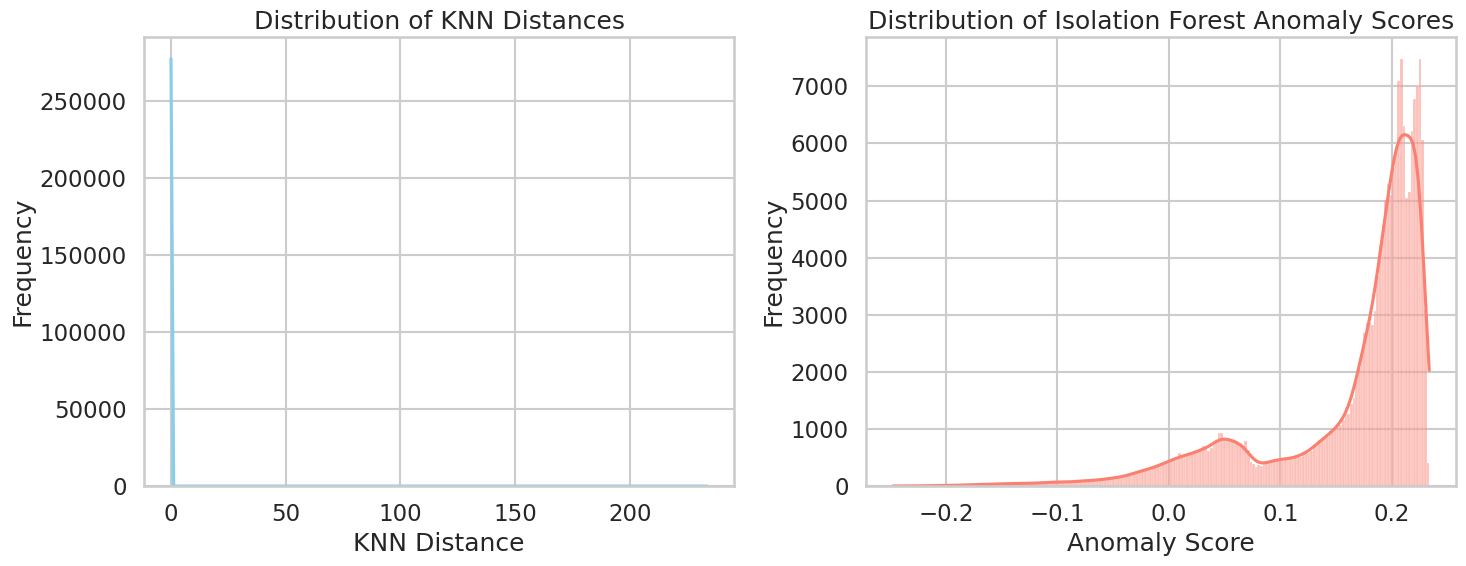

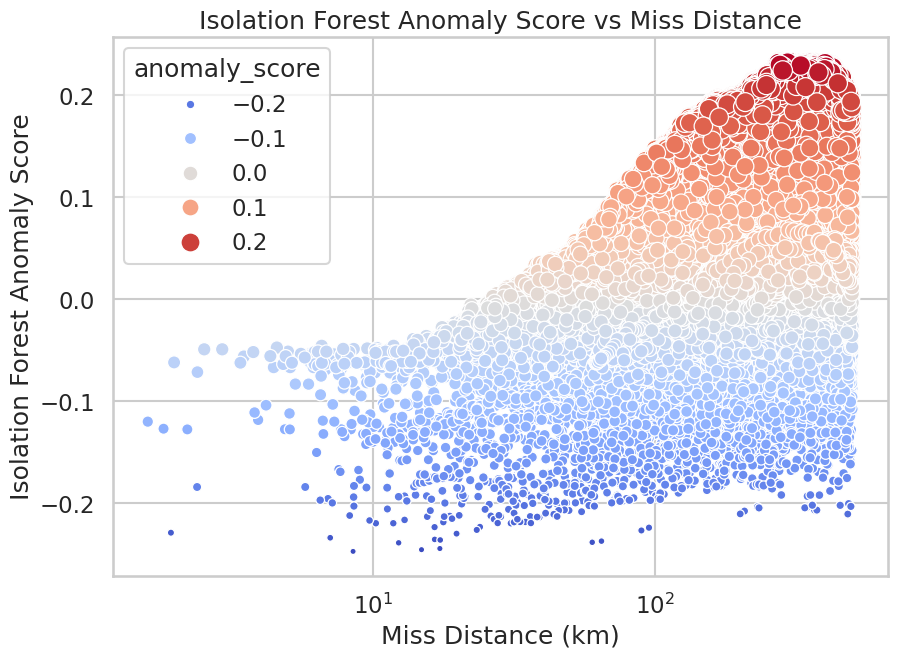

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

if df is not None and 'knn_distance' in df.columns and 'anomaly_score' in df.columns:
    # Set style for plots
    sns.set_style("whitegrid")

    plt.figure(figsize=(15, 6))

    # Histogram for KNN Distance
    plt.subplot(1, 2, 1)
    sns.histplot(df['knn_distance'], kde=True, color='skyblue')
    plt.title('Distribution of KNN Distances')
    plt.xlabel('KNN Distance')
    plt.ylabel('Frequency')

    # Histogram for Isolation Forest Anomaly Scores
    plt.subplot(1, 2, 2)
    sns.histplot(df['anomaly_score'], kde=True, color='salmon')
    plt.title('Distribution of Isolation Forest Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Scatter plot: Anomaly Score vs Miss Distance
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='miss_distance', y='anomaly_score', hue='anomaly_score', data=df,
                    palette='coolwarm', size='anomaly_score', sizes=(20, 200), legend='brief')
    plt.title('Isolation Forest Anomaly Score vs Miss Distance')
    plt.xlabel('Miss Distance (km)')
    plt.ylabel('Isolation Forest Anomaly Score')
    plt.xscale('log') # Use log scale for miss_distance if values vary widely
    plt.show()
else:
    print("DataFrame 'df' or required columns ('knn_distance', 'iso_anomaly_score') are not available. Please ensure the data file is uploaded and processed correctly.")

In [36]:
df.columns

Index(['conjunction_id', 'comment_header', 'creation_date', 'originator',
       'message_id', 'event_id', 'comment_relative_metadata_data', 'tca',
       'miss_distance', 'relative_speed',
       ...
       'object2_ctdot_rdot', 'object2_ctdot_tdot', 'object2_cndot_r',
       'object2_cndot_t', 'object2_cndot_n', 'object2_cndot_rdot',
       'object2_cndot_tdot', 'object2_cndot_ndot', 'knn_distance',
       'anomaly_score'],
      dtype='object', length=119)

In [40]:
df.isnull().sum()

conjunction_id        0
comment_header        0
creation_date         0
originator            0
message_id            0
                     ..
object2_cndot_rdot    0
object2_cndot_tdot    0
object2_cndot_ndot    0
knn_distance          0
anomaly_score         0
Length: 119, dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185511 entries, 0 to 185510
Columns: 119 entries, conjunction_id to anomaly_score
dtypes: float64(38), int64(41), object(40)
memory usage: 168.4+ MB


In [42]:
# Drop columns that are entirely NaN
nan_columns = df.columns[df.isnull().all()]
df = df.drop(columns=nan_columns)
print(f"Dropped {len(nan_columns)} columns where all values were NaN: {nan_columns.tolist()}")

# Identify columns where all values are zero
zero_columns = (df == 0).all(axis=0)

# Get the names of these columns
columns_to_drop = df.columns[zero_columns]

# Drop the identified columns
df = df.drop(columns=columns_to_drop)

print(f"Dropped {len(columns_to_drop)} columns where all values were zero: {columns_to_drop.tolist()}")
print("Remaining columns:", df.columns.tolist())

Dropped 2 columns where all values were NaN: ['previous_message_id', 'object2_operator_organization']
Dropped 36 columns where all values were zero: ['object1_ct_r', 'object1_cn_r', 'object1_cn_t', 'object1_crdot_r', 'object1_crdot_t', 'object1_crdot_n', 'object1_crdot_rdot', 'object1_ctdot_r', 'object1_ctdot_t', 'object1_ctdot_n', 'object1_ctdot_rdot', 'object1_ctdot_tdot', 'object1_cndot_r', 'object1_cndot_t', 'object1_cndot_n', 'object1_cndot_rdot', 'object1_cndot_tdot', 'object1_cndot_ndot', 'object2_ct_r', 'object2_cn_r', 'object2_cn_t', 'object2_crdot_r', 'object2_crdot_t', 'object2_crdot_n', 'object2_crdot_rdot', 'object2_ctdot_r', 'object2_ctdot_t', 'object2_ctdot_n', 'object2_ctdot_rdot', 'object2_ctdot_tdot', 'object2_cndot_r', 'object2_cndot_t', 'object2_cndot_n', 'object2_cndot_rdot', 'object2_cndot_tdot', 'object2_cndot_ndot']
Remaining columns: ['conjunction_id', 'comment_header', 'creation_date', 'originator', 'message_id', 'event_id', 'comment_relative_metadata_data', '

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_curve, auc, precision_recall_curve)

# Statistical Analysis
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# Feature Engineering & Orbital Parameter Extraction

# %%
def calculate_orbital_parameters(df):
    """
    Calculate orbital parameters from state vectors (position & velocity)
    """
    print("Calculating orbital parameters...")

    # Earth parameters
    MU_EARTH = 398600.4418  # km^3/s^2 (Earth's gravitational parameter)
    EARTH_RADIUS = 6371.0   # km

    # Extract position and velocity for both objects
    for obj in ['object1', 'object2']:
        # Position (km)
        r_x = df[f'{obj}_x']
        r_y = df[f'{obj}_y']
        r_z = df[f'{obj}_z']

        # Velocity (km/s)
        v_x = df[f'{obj}_x_dot']
        v_y = df[f'{obj}_y_dot']
        v_z = df[f'{obj}_z_dot']

        # Calculate position magnitude (orbital radius)
        r_mag = np.sqrt(r_x**2 + r_y**2 + r_z**2)

        # Calculate velocity magnitude
        v_mag = np.sqrt(v_x**2 + v_y**2 + v_z**2)

        # Calculate altitude
        altitude = r_mag - EARTH_RADIUS

        # Calculate specific angular momentum
        h_x = r_y * v_z - r_z * v_y
        h_y = r_z * v_x - r_x * v_z
        h_z = r_x * v_y - r_y * v_x
        h_mag = np.sqrt(h_x**2 + h_y**2 + h_z**2)

        # Calculate eccentricity vector
        v_mag_sq = v_mag**2
        r_dot_v = r_x * v_x + r_y * v_y + r_z * v_z

        e_x = (v_mag_sq - MU_EARTH / r_mag) * r_x / MU_EARTH - r_dot_v * v_x / MU_EARTH
        e_y = (v_mag_sq - MU_EARTH / r_mag) * r_y / MU_EARTH - r_dot_v * v_y / MU_EARTH
        e_z = (v_mag_sq - MU_EARTH / r_mag) * r_z / MU_EARTH - r_dot_v * v_z / MU_EARTH

        # Handle potential NaNs/infs in eccentricity calculation (e.g., if r_mag is zero)
        eccentricity = np.sqrt(e_x**2 + e_y**2 + e_z**2)
        eccentricity = np.nan_to_num(eccentricity, nan=0.0)

        # Calculate semi-major axis
        specific_energy = v_mag_sq / 2 - MU_EARTH / r_mag
        # Handle division by zero for semi_major_axis if specific_energy is 0 (parabolic) or very close to it
        semi_major_axis = np.where(specific_energy != 0, -MU_EARTH / (2 * specific_energy), np.nan)
        semi_major_axis = np.nan_to_num(semi_major_axis, nan=0.0) # Replace NaN with 0 or a large placeholder if desired

        # Calculate inclination (degrees)
        # Avoid division by zero if h_mag is 0
        inclination = np.where(h_mag != 0, np.degrees(np.arccos(h_z / h_mag)), 0.0) # Assign 0 if h_mag is 0
        inclination = np.nan_to_num(inclination, nan=0.0) # Ensure no NaNs from arccos if input is out of range

        # Store calculated parameters
        df[f'{obj}_altitude_km'] = altitude
        df[f'{obj}_semi_major_axis_km'] = semi_major_axis
        df[f'{obj}_eccentricity'] = eccentricity
        df[f'{obj}_inclination_deg'] = inclination
        df[f'{obj}_velocity_km_s'] = v_mag

    # Calculate mean orbital parameters for conjunction
    df['mean_altitude_km'] = (df['object1_altitude_km'] + df['object2_altitude_km']) / 2
    df['mean_inclination_deg'] = (df['object1_inclination_deg'] + df['object2_inclination_deg']) / 2
    df['delta_inclination_deg'] = np.abs(df['object1_inclination_deg'] - df['object2_inclination_deg'])

    print("✅ Orbital parameters calculated")

    return df

# Calculate orbital parameters
df = calculate_orbital_parameters(df)

# Display new parameters
orbital_params = ['mean_altitude_km', 'object1_eccentricity', 'object2_eccentricity',
                 'mean_inclination_deg', 'delta_inclination_deg']

print("\nOrbital parameter statistics:")
display(df[orbital_params].describe())

# Visualize altitude distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df['mean_altitude_km'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Mean Altitude (km)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Altitude Distribution of Conjunction Events', fontsize=14, fontweight='bold')
plt.axvline(400, color='red', linestyle='--', label='400 km')
plt.axvline(800, color='orange', linestyle='--', label='800 km')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['mean_inclination_deg'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Mean Inclination (degrees)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Inclination Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('orbital_parameter_distribution.png', dpi=300, bbox_inches='tight')
plt.show()